<a href="https://colab.research.google.com/github/kwanderer/MachineLearning/blob/main/DataInjection100-100Regresion_Multi_Class_MD_LSTM_step_200_files_120.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Datu kopa

Datu kopas avots: https://www.kaggle.com/uysalserkan/fault-induction-motor-dataset

Darbā tiek izmantota indukcijas motora parametru datu bāze. Izmantotajā datu kopā ir dati, kas tika iegūti SpectraQuest aparatūras kļūdu simulatorā (Machinery Fault Simulator).

Katra mērījumu secība tika ģenerēta ar frekvenci 50 kHz 5 sekunžu laikā, kopā 250 000 mērījumi.


Dati ir apkopoti tabulā, kura satur 8 parametrus. Dati ir iedalīti sekojošās kolonas:

**tachometer** – tahometra signāls, kas ļauj novērtēt rotācijas frekvenci

**und-accelerometer-axial** - apakšā esošā gultņa akselerometrs (aksiālais virziens)

**und-accelerometer-radial** – apakšā esošā gultņa akselerometrs (radiālais virziens)

**und-accelerometer-tangential** - apakšā esošā gultņa akselerometrs (tangenciālais virziens)

**over-accelerometer-axial** - pārkares gultņa akselerometrs (aksiālais virziens)

**over-accelerometer-radial** – pārkares gultņa akselerometrs (radiālais  virziens)

**over-accelerometer-tangential**  - pārkares gultņa akselerometrs (tangenciālais virziens)

**microphone** – mikrofona vērtība


#Datu ielasīšana un satura vizualizācija

In [226]:
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn import linear_model  #pip install sklearn - loti plasa masinapmacibas biblioteka
from sklearn.linear_model import LinearRegression  
import csv          #pip install csv - darbam ar CSV datu kopam
import requests     #pip install requests  - vienkarsakam darbam ar tiessaistes CSV datu kopam tiessaistes

import matplotlib
import matplotlib.pyplot as plt

import glob


In [227]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [228]:
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/cutted/")
dataNormal =  pd.read_csv("Normal.csv")
dataImbalance6 =  pd.read_csv("Imbalance6.csv")
dataImbalance10 =  pd.read_csv("Imbalance10.csv")
dataImbalance15 =  pd.read_csv("Imbalance15.csv")
dataImbalance20 =  pd.read_csv("Imbalance20.csv")
dataImbalance25 =  pd.read_csv("Imbalance25.csv")
dataImbalance30 =  pd.read_csv("Imbalance30.csv")
dataImbalance35 =  pd.read_csv("Imbalance35.csv")

In [229]:
dataNormal.info()
dataImbalance6.info()
dataImbalance10.info()
dataImbalance15.info()
dataImbalance20.info()
dataImbalance25.info()
dataImbalance30.info()
dataImbalance35.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245972 entries, 0 to 245971
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   tachometer                     245972 non-null  float64
 1   und-accelerometer-axial        245972 non-null  float64
 2   und-accelerometer-radial       245972 non-null  float64
 3   und-accelerometer-tangential   245972 non-null  float64
 4   over-accelerometer-axial       245972 non-null  float64
 5   over-accelerometer-radial      245972 non-null  float64
 6   over-accelerometer-tangential  245972 non-null  float64
 7   microphone                     245972 non-null  float64
 8   Class                          245972 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 16.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248391 entries, 0 to 248390
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype

In [230]:
rec_count = len(dataNormal)
rec_count

245972

# Datu dalīšana mazākos gabalos

In [231]:
sequence_length = 200

In [232]:
def generate_data(X, y, X2, y2, sequence_length = 200, step = 10, sequence_length1 = 100):
    X_local = []
    y_local = []
    for start in range(0, len(dataNormal) - sequence_length, step):
        end = start + sequence_length
        sequenceNormalEnd = start + sequence_length1
        X_local.append(np.concatenate((X[start:sequenceNormalEnd], X2[sequenceNormalEnd:end])))
        #X_local.append()
        y_local.append(y2[end-1])
    return np.array(X_local), np.array(y_local)

X_sequence, y = generate_data(dataNormal.loc[:,"tachometer":"microphone"].values, dataNormal.Class, dataImbalance35.loc[:,"tachometer" :"microphone"].values, dataImbalance35.Class)
#X_sequence, y = generate_data(data.loc[:, ["und-accelerometer-axial", "und-accelerometer-radial", "und-accelerometer-tangential", "microphone"]].values, data.Class)


In [233]:
X_sequence.shape, y.shape

((24578, 200, 8), (24578,))

In [234]:
y

array([1, 1, 1, ..., 1, 1, 1])

In [235]:
i = 0
while i < 24578:
  if y[i] == 1:
    y[i] = 7
  elif y[i] == 2:
    y[i] = 6
  elif y[i] == 3:
    y[i] = 5
  elif y[i] == 4:
    y[i] = 4
  elif y[i] == 5:
    y[i] = 3
  elif y[i] == 6:
    y[i] = 2
  elif y[i] == 7:
    y[i] = 1
  i+=1

In [236]:
y

array([7, 7, 7, ..., 7, 7, 7])

In [237]:
unique, counts = np.unique(y, return_counts=True)

In [238]:
unique

array([7])

In [239]:
counts

array([24578])

In [240]:
data = 0

In [241]:
#from sklearn.preprocessing import OneHotEncoder

In [242]:
#label_encoder = OneHotEncoder(sparse=False)
#label_encoder.fit(y.reshape(-1,1))

In [243]:
#y_encoded = label_encoder.transform(y.reshape(-1,1))

In [244]:
#y_encoded[0:5]

In [245]:
#y=y_encoded

# Random/Shuffle

In [246]:
#shuffler = np.random.RandomState(seed=42).permutation(len(X_sequence))
#X_sequence_shuffled = X_sequence[shuffler]
#y_shuffled = y[shuffler]

# LSTM

In [247]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
import seaborn as sns 
%matplotlib inline
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [248]:
#from tensorflow.keras import optimizers
#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#model = keras.Sequential()
#model.add(LSTM(100, input_shape = (200, 8)))
#model.add(Dropout(0.5))
#model.add(Dense(1, activation="softmax"))


#model.compile(loss="categorical_crossentropy"
#              , metrics=[keras.metrics.binary_accuracy]
#              , optimizer='sgd')

#model.summary()

In [249]:
#from tensorflow.keras import optimizers
##sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#optimizer = tf.keras.optimizers.Adam(lr=0.0001)
#model = keras.Sequential()
#model.add(LSTM(100, input_shape = (200, 8)))
#model.add(Dropout(0.5))
#model.add(Dense(1))# dense 1, activation - relu/sigmoid

##model.compile(loss='mean_squared_error', optimizer=sgd)
#model.compile(loss="mse" #mse
#              , metrics=['accuracy']
#              , optimizer=optimizer)

#model.summary()

In [250]:
from tensorflow.keras import optimizers
#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model = keras.Sequential()
model.add(LSTM(300, input_shape = (200, 8)))
model.add(Dropout(0.5))
model.add(Dense(1))# dense 1, activation - relu/sigmoid

#model.compile(loss='mean_squared_error', optimizer=sgd)
model.compile(loss="mse" #mse
              , metrics=['accuracy']
              , optimizer=optimizer)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 300)               370800    
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 301       
                                                                 
Total params: 371,101
Trainable params: 371,101
Non-trainable params: 0
_________________________________________________________________


In [251]:
#training_size = int(len(X_sequence) * 0.8)
#val_size = int(len(X_sequence) * 0.9)

In [252]:
#X_train, y_train = X_sequence_shuffled[:training_size], y_shuffled[:training_size]
#X_val, y_val = X_sequence_shuffled[training_size:val_size], y_shuffled[training_size:val_size]
#X_test, y_test = X_sequence_shuffled[val_size:], y_shuffled[val_size:]

In [253]:
from keras.models import load_model
os.chdir("/content/gdrive/MyDrive/Colab Notebooks/")
# Assuming your model includes instance of an "AttentionLayer" class
uploadmodel = load_model('data_multiclass/RegresionMulticlassModel_E100_B64.h5')
#custom_ob = {'att_out': custom_layer.Attention,'AttLayer2': custom_layer.Attention}
#new_model = load_model('test.h5', custom_objects={'AttentionLayer': att_out})
#new_model = tf.keras.models.load_model('test.h5',custom_objects={'att_out': custom_layer.Attention})

# Show the model architecture
uploadmodel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               370800    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 371,101
Trainable params: 371,101
Non-trainable params: 0
_________________________________________________________________


In [254]:
#history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val, y_val))
#model.save('NewAllDataModel_E100_B64.h5')

In [255]:
test_acc = uploadmodel.evaluate(X_sequence, y)

769/769 [==============================] - 161s 208ms/step - loss: 19.5834 - accuracy: 0.0000e+00


In [256]:
test_acc

[19.583393096923828, 0.0]

In [257]:
y_test_prob = uploadmodel.predict(X_sequence, verbose=1)

769/769 [==============================] - 162s 210ms/step


In [258]:
np.set_printoptions(suppress=True)
y_test_prob_backup = y_test_prob
y_test_prob

array([[0.57],
       [0.51],
       [0.62],
       ...,
       [6.08],
       [6.35],
       [6.27]], dtype=float32)

(array([ 8764.,  1268.,   201.,   165.,   111.,   140.,   135.,   292.,
        12418.,  1084.]),
 array([-0.46,  0.38,  1.22,  2.06,  2.9 ,  3.74,  4.58,  5.42,  6.26,
         7.1 ,  7.93], dtype=float32),
 <a list of 10 Patch objects>)

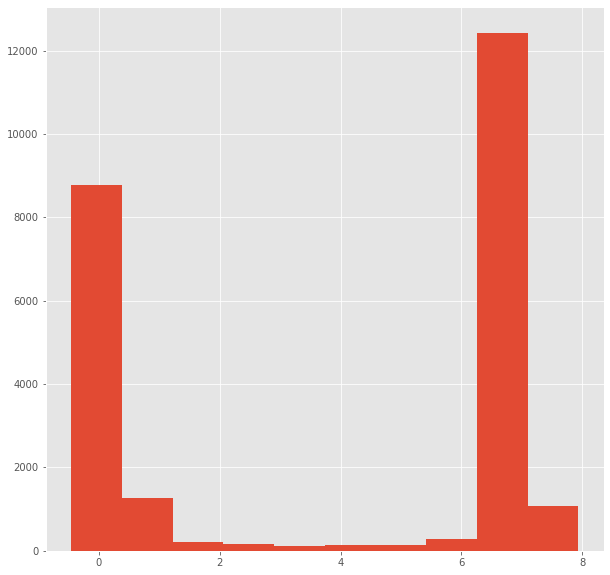

In [259]:
plt.figure(figsize=(10,10))
plt.hist(y_test_prob_backup)

In [260]:
y_test_prob_backup[:10]

array([[0.57],
       [0.51],
       [0.62],
       [0.46],
       [0.52],
       [0.56],
       [0.48],
       [0.64],
       [0.49],
       [0.59]], dtype=float32)

In [261]:
from sklearn.metrics import multilabel_confusion_matrix

In [262]:
y_test_prob

array([[0.57],
       [0.51],
       [0.62],
       ...,
       [6.08],
       [6.35],
       [6.27]], dtype=float32)

In [263]:
y_test_pred = np.reshape(y_test_prob, -1)

In [264]:
y_test_pred

array([0.57, 0.51, 0.62, ..., 6.08, 6.35, 6.27], dtype=float32)

In [265]:
y_test_pred_int = np.round(y_test_pred)
print(y_test_pred_int)
y_test_pred_int = y_test_pred_int.astype(int)

[1. 1. 1. ... 6. 6. 6.]


In [266]:
y_test_pred_int

array([1, 1, 1, ..., 6, 6, 6])

In [267]:
cfm=confusion_matrix(y, y_test_pred_int)

In [268]:
cfm

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0],
       [ 9279,   817,   231,   143,   164,   169,   564, 13199,    12],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0]])

In [269]:
 print(classification_report(y, y_test_pred_int))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       1.00      0.54      0.70     24578
           8       0.00      0.00      0.00         0

    accuracy                           0.54     24578
   macro avg       0.11      0.06      0.08     24578
weighted avg       1.00      0.54      0.70     24578



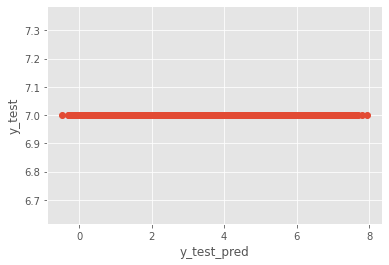

In [270]:
plt.plot(y_test_pred, y, 'o')
#plt.title('')
plt.ylabel('y_test')
plt.xlabel('y_test_pred')
plt.show()

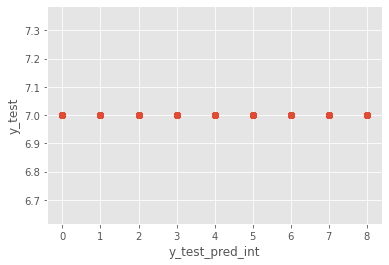

In [271]:
plt.plot(y_test_pred_int, y, 'o')
#plt.title('')
plt.ylabel('y_test')
plt.xlabel('y_test_pred_int')
plt.show()

In [272]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [273]:
plot_learningCurve(history, 100)

NameError: ignored

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [ 9279   817   231   143   164   169   564 13199    12]
 [    0     0     0     0     0     0     0     0     0]]
Normalized confusion matrix
[[ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [0.38 0.03 0.01 0.01 0.01 0.01 0.02 0.54 0.  ]
 [ nan  nan  nan  nan  nan  nan  n

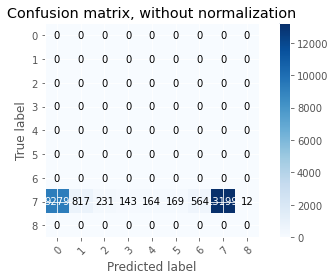

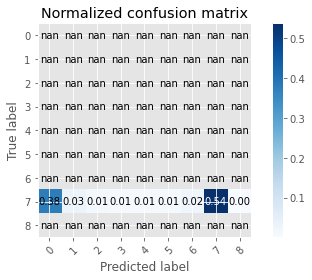

In [283]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8'])

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh or (cm[i, j] > 0.5 and cm[i, j] < 0.6 )else "black")
    fig.tight_layout()

    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y, y_test_pred_int, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y, y_test_pred_int, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()